<a href="https://colab.research.google.com/github/kmkkkp/bigdata_security/blob/main/data237_intervaltimes_normvsfuzzy_autoencoderIF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# importing pandas
import numpy as np
import pandas as pd
from pandas.core.internals.blocks import F

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import neighbors, datasets
#from sklearn.inspection import DecisionBoundaryDisplay

import sklearn.metrics
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

In [30]:
#col = [0,1,2,3,4,5,6,7,8,9,10,11]
Fuzzy=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/preprocessing_data/Fuzzy_dataset_pre.csv', index_col = 0)
#,usecols = col

In [19]:
print(Fuzzy)
Fuzzy.info()
Fuzzy.head()
Fuzzy['Label'].value_counts()

            Timestamp  CANID  DLC  Data[0]  Data[1]  Data[2]  Data[3]  \
0        1.478196e+09   1349    8      216        0        0      138   
1        1.478196e+09    688    5      255      127        0        5   
2        1.478196e+09      2    8        0        0        0        0   
3        1.478196e+09    339    8        0       33       16      255   
4        1.478196e+09    304    8       25      128        0      255   
...               ...    ...  ...      ...      ...      ...      ...   
3838855  1.478201e+09    399    8      254       89        0        0   
3838856  1.478201e+09    608    8       24       33       33       48   
3838857  1.478201e+09    672    8       36        0      154       29   
3838858  1.478201e+09    809    8      220      183      127       20   
3838859  1.478201e+09   1349    8      216        0        0      139   

         Data[4]  Data[5]  Data[6]  Data[7]  Label  interval_prev  \
0              0        0        0        0      0    

0    3347013
2     491847
Name: Label, dtype: int64

In [31]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X = Fuzzy.drop(['Label'], axis = 1)
Y = Fuzzy['Label']

In [32]:
Y.value_counts()

0    3347013
2     491847
Name: Label, dtype: int64

In [33]:
a=0
b=0
for test in Y.values:
  if test == 2:
    a+=1
  else: b+=1
print(a, b)


491847 3347013


In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size=0.2, random_state=1)

In [36]:
a=0
b=0
for test in Y_train.values:
  if test == 2:
    a+=1
  else: b+=1
print(a, b)


393478 2677610


In [37]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Autoencoder 클래스 정의
class Autoencoder(BaseEstimator, TransformerMixin):
    def __init__(self, input_dim, encoding_dim, optimizer='adam', epochs=10, batch_size=32):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.optimizer = optimizer
        self.epochs = epochs
        self.batch_size = batch_size
        self.autoencoder = None

    def fit(self, X, y=None):
        input_layer = Input(shape=(self.input_dim,))
        encoded = Dense(self.encoding_dim, activation='relu')(input_layer)
        decoded = Dense(self.input_dim, activation='sigmoid')(encoded)

        self.autoencoder = Model(inputs=input_layer, outputs=decoded)
        self.autoencoder.compile(optimizer=self.optimizer, loss='mse')

        self.autoencoder.fit(X, X, epochs=self.epochs, batch_size=self.batch_size, verbose=0)

        return self

    def transform(self, X):
        encoder = Model(inputs=self.autoencoder.input, outputs=self.autoencoder.get_layer(index=1).output)
        encoded_X = encoder.predict(X)
        return encoded_X

In [39]:
autoencoder_params = {
    'input_dim': X_train.shape[1],
    'encoding_dim': 9,
    'optimizer': 'adam',
    'epochs': 10,
    'batch_size': 32
}

In [40]:
# Autoencoder 모델 학습
autoencoder = Autoencoder(
    input_dim=autoencoder_params['input_dim'],
    encoding_dim=autoencoder_params['encoding_dim'],
    optimizer=autoencoder_params['optimizer'],
    epochs=autoencoder_params['epochs'],
    batch_size=autoencoder_params['batch_size']
)
autoencoder.fit(X_train)

Autoencoder(encoding_dim=9, input_dim=14)

In [41]:
# Autoencoder를 사용하여 특징 추출
encoded_X_train = autoencoder.transform(X_train)
encoded_X_test = autoencoder.transform(X_test)

23993/23993 [==============================] - 31s 1ms/step


# **IF_REAL**

In [42]:
from sklearn.ensemble import IsolationForest
outlier_fraction = a/b

print(outlier_fraction)


0.14695119901703385


In [43]:

# Isolation Forest 모델 생성 및 학습
clf = IsolationForest(n_estimators=100, max_samples=len(X), contamination=outlier_fraction,random_state=5, verbose=0)  # 이상치 비율 설정
clf.fit(encoded_X_train)
scores_prediction = clf.decision_function(encoded_X_train)
y_pred = clf.predict(encoded_X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_iforest.py:307: UserWarning: max_samples (3838860) is greater than the total number of samples (3071088). max_samples will be set to n_samples for estimation.
  warn(


In [44]:
#Reshape the prediction values to 0 for Valid transactions , 2 for Fraud transactions
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 2

Accuracy Score :
0.9580109720073147
Classification Report :
              precision    recall  f1-score   support

           0       0.99      0.96      0.98    669403
           2       0.79      0.91      0.85     98369

    accuracy                           0.96    767772
   macro avg       0.89      0.94      0.91    767772
weighted avg       0.96      0.96      0.96    767772



<Axes: >

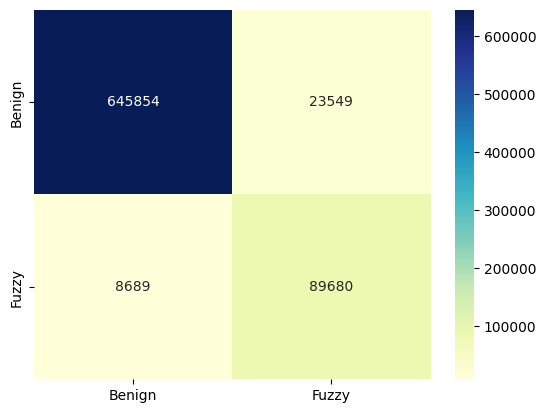

In [46]:

#y_pred랑 y_test랑 비교해야함
import seaborn
print("Accuracy Score :")
print(accuracy_score(Y_test,y_pred))
print("Classification Report :")
print(classification_report(Y_test,y_pred))

cm = confusion_matrix(Y_test, y_pred)

cm_matrix = pd.DataFrame(data=cm, columns=['Benign','Fuzzy'], 
                              index=['Benign', 'Fuzzy'])

seaborn.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')